## Homework 4 (due 2017-11-27)

Implement a solver for the shallow water equations, $$ \begin{bmatrix} h \\ h u \end{bmatrix}_t + \begin{bmatrix} hu \\ hu^2 + \frac g 2 h^2 \end{bmatrix}_x = 0 $$ where $h$ is water thickness, $hu$ is the momentum of a column of water, and $g$ is the gravitational potential. The shallow water equations are very similar to isothermal gas dynamics except that the wave speed $c$ is not constant, but rather $\pm \sqrt{gh}$ as can be seen from the eigenvalues of the flux Jacobian.

Choose initial conditions for your numerical experiments that create all possible configurations of subsonic and supersonic shocks and rarefactions.

The total energy in the system is kinetic plus potential energy $$ E = \int_{\Omega} \frac h 2 u^2 + \frac g 2 h^2 . $$ Compare the evolution of total energy using a first order method and a method using slope reconstruction, for a configuration with a shock and a configuration with only rarefactions.

Does the result depend on your choice of Riemann solver, e.g., between HLL and Rusanov or between an exact solver and HLL? Does it depend on your choice of limiter in slope reconstruction?

In [43]:
import numpy 
from matplotlib import pyplot
%run fdtools.py
limiters = []
def limappend(lim):
    limiters.append(lim)
    return lim

@limappend
def limit_zero(r):
    return 0*r

@limappend
def limit_none(r):
    return 0*r+1

@limappend
def limit_minmod(r):
    return numpy.maximum(numpy.minimum(2*r, 2*(1-r)), 0)

@limappend
def limit_sin(r):
    return numpy.where(numpy.all((0 < r, r < 1), axis=0),
                      numpy.sin(numpy.pi*r),
                      0)

@limappend
def limit_vl(r):
    return numpy.maximum(4*r*(1-r), 0)

@limappend
def limit_bj(r):
    return numpy.clip(numpy.minimum(4*r, 4*(1-r)), 0, 1)


## Exact Riemann Solver
The initial conditions below exhibit both sub and supersonic shocks and rarefactions. 

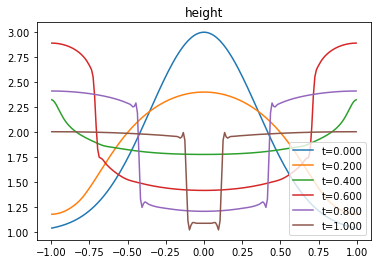

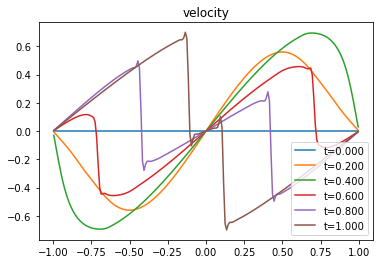

In [79]:
def flux_shallow(U):
    hh = U[0]
    u = U[1] / hh
    return numpy.array([U[1], U[1]*u + 0.5*hh**2])

def fvsolve2system(riemann, U0, a=-1, b=1, n=20, tfinal=1, limit=limit_minmod, args = ()):
    h = (b - a)/n
    x = numpy.linspace(a+h/2, b-h/2, n) # Element midpoints (centroids)
    U0x = U0(x)
    Ushape = U0x.shape
    idxL = numpy.arange(-1, n-1)
    idxR = numpy.arange(1, n+1) % n
    def rhs(t, U):
        U = U.reshape(Ushape)
        jump = U[:,idxR] - U[:,idxL]
        r = numpy.zeros_like(jump)
        numpy.divide(U - U[:,idxL], jump, out=r, where=(jump!=0))
        g = limit(r) * jump / (2*h)
        fluxL = riemann(U[:,idxL] + g[:,idxL] * h/2, U - g * h/2, *args)
        return (fluxL - fluxL[:,idxR]).flatten() / h
    hist = ode_rkexplicit(rhs, U0x.flatten(), h=h/2, tfinal=tfinal)
    return x, [(t, U.reshape(Ushape)) for t, U in hist]

def c(h):
    return numpy.sqrt(numpy.absolute(h))


def riemann_shallow(UL, UR, maxit=60):
    rhoL = UL[0]
    rhoR = UR[0]
    uL = UL[1] / rhoL
    uR = UR[1] / rhoR
    rho = .5*(rhoL + rhoR)  # Initial guess to Newton solve
    
    for i in range(maxit):
        ujumpL = numpy.where(rho > rhoL,
                            (rhoL - rho) / numpy.sqrt(rho*rhoL),    # shock
                            c(rhoL) * (numpy.log(rhoL) - numpy.log(rho))) # rarefaction
        ujumpR = numpy.where(rho > rhoR,
                            (rhoR - rho) / numpy.sqrt(rho*rhoR),    # shock
                            c(rhoR) * (numpy.log(rhoR) - numpy.log(rho))) # rarefaction
        residual = ujumpL + ujumpR - (uR - uL)
        # print('{: 2d} {:10.2e} {:5f} {:5f}'.format(i, numpy.linalg.norm(residual), min(rho), max(rho)))
        if numpy.linalg.norm(residual) < 1e-10:
            u = uL + ujumpL
            break
        elif i+1 == maxit:
            raise RuntimeError('Newton solver failed to converge')
        dujumpL = numpy.where(rho > rhoL,
                             -(1 + .5*(rhoL - rho)/rho)/numpy.sqrt(rho*rhoL), # shock
                              -c(rho) / rho)                                       # rarefaction
        dujumpR = numpy.where(rho > rhoR,
                             -(1 + .5*(rhoR - rho)/rho)/numpy.sqrt(rho*rhoR), # shock
                              -c(rho) / rho)                                       # rarefaction
        delta_rho = -residual / (dujumpL + dujumpR)
        while min(rho + delta_rho) <= 0:  # line search to prevent negative density
            delta_rho *= .5
        rho += delta_rho
        
    U0 = numpy.zeros_like(UL)
    for i in range(len(rho)):
        if uL[i] - c(rhoL[i]) < 0 < u[i] - c(rho[i]) or u[i] + c(rho[i]) < 0 < uR[i] + c(rhoR[i]):
            # Inside left (right) sonic rarefaction
            U0[0,i] = numpy.exp(-(u[i] - numpy.sign(u[i])*c(rho[i]) - c*numpy.log(rho[i]))/c(rho[i]))
            U0[1,i] = U0[0,i] * numpy.sign(u[i])*c(rho[i])
        elif ((rhoL[i] >= rho[i] and 0 <= uL[i] - c(rhoL[i])) or
              (rhoL[i] < rho[i] and 0 < (rho[i]*u[i] - UL[1,i]))):
            # Left rarefaction or shock is supersonic
            U0[:,i] = UL[:,i]
        elif ((rhoR[i] >= rho[i] and uR[i] + c(rhoR[i]) <= 0) or
              (rhoR[i] < rho[i] and UR[1][i] - rho[i]*u[i]) > 0):
            # Right rarefaction or shock is supersonic
            U0[:,i] = UR[:,i]
        else:
            # Sample star state
            U0[0,i] = rho[i]
            U0[1,i] = rho[i]*u[i]
    return flux_shallow(U0)

def initial_shallow(x):
    return numpy.array([1 + 2*(numpy.exp(-(x*2)**2)),
                        0*x])

x, hist = fvsolve2system(riemann_shallow, initial_shallow, n=200, limit=limit_none, args=())
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.title('height')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.title('velocity')
pyplot.legend(loc='lower right');
pyplot.show()

## Approximate HLL Riemann Solver
Below we implement an HLL solver for the shallow wave equations, slightly altered from the in-class code for isothermal gas dynamics. For $c=\pm \sqrt{gh}$ we let $g=1$.

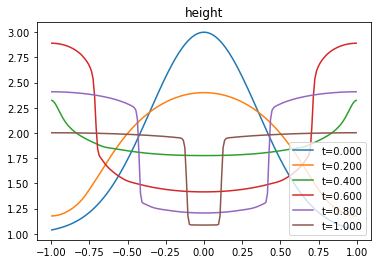

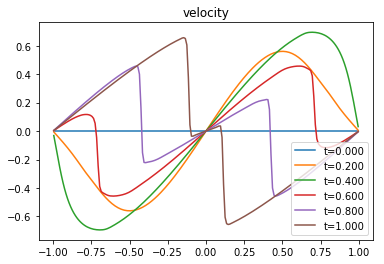

In [80]:

def riemann_shallow_hll(UL, UR):
    rhoL = UL[0]
    rhoR = UR[0]
    uL = UL[1] / rhoL
    uR = UR[1] / rhoR
    sL = numpy.minimum(uL - c(rhoL), uR - c(rhoR))
    sR = numpy.maximum(uL + c(rhoL), uR + c(rhoR))
    fL = flux_shallow(UL)
    fR = flux_shallow(UR)
    return numpy.where(sL > 0, fL,
                       numpy.where(sR < 0, fR,
                                   (sR*fL - sL*fR + sL*sR*(UR - UL)) / (sR-sL)))


x, hist = fvsolve2system(riemann_shallow_hll, initial_shallow, n=200, limit=limit_vl, args=())
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.title('height')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.title('velocity')
pyplot.legend(loc='lower right');
pyplot.show()


## Approximate Rusanov Solver

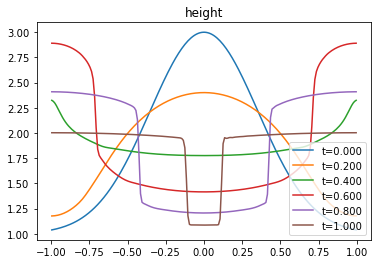

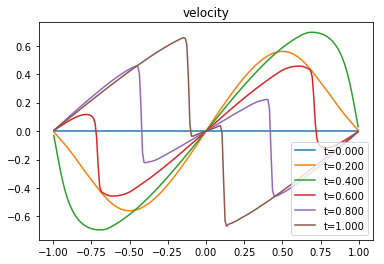

In [81]:
def riemann_shallow_rusanov(UL, UR):
    rhoL = UL[0]
    rhoR = UR[0]
    uL = UL[1] / rhoL
    uR = UR[1] / rhoR
    s = numpy.maximum(uL + c(rhoL), uR + c(rhoR))
    fL = flux_shallow(UL)
    fR = flux_shallow(UR)
    return (0.5*(fL + fR) -0.5*s*(UR - UL))


x, hist = fvsolve2system(riemann_shallow_rusanov, initial_shallow, n=200, limit=limit_vl, args=())
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.title('height')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.title('velocity')
pyplot.legend(loc='lower right');
pyplot.show()

## Subsonic waves

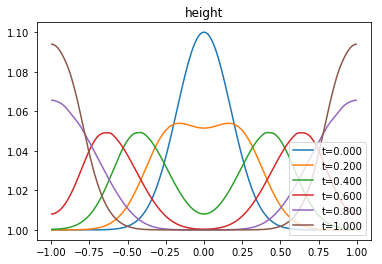

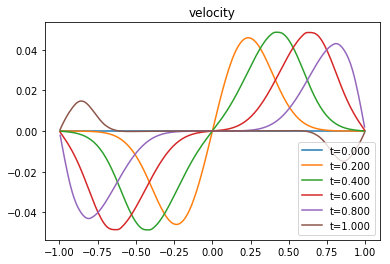

In [82]:
def initial_shallow_sub(x):
    return numpy.array([1 + 0.1*(numpy.exp(-(x*4)**2)),
                        0*x])

x, hist = fvsolve2system(riemann_shallow_hll, initial_shallow_sub, n=200, limit=limit_vl, args=())
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.title('height')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.title('velocity')
pyplot.legend(loc='lower right');
pyplot.show()

## Supersonic waves

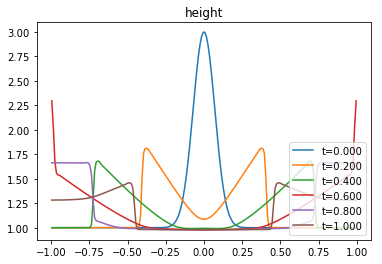

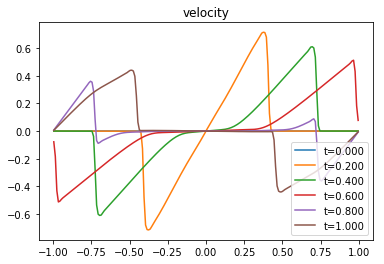

In [83]:
def initial_shallow_super(x):
    return numpy.array([1 + 2*(numpy.exp(-(x*10)**2)),
                        0*x])

x, hist = fvsolve2system(riemann_shallow_hll, initial_shallow_super, n=200, limit=limit_vl, args=())
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.title('height')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.title('velocity')
pyplot.legend(loc='lower right');
pyplot.show()

## Evolution of Total Energy 
Below we compute the evolution of the conservation of total energy in time, with initial conditions that exhibit subsonic waves until $t \approx 0.5$ and supersonic shocks thereafter. We use an HLL solver and compare to exact and Rusanov solvers.

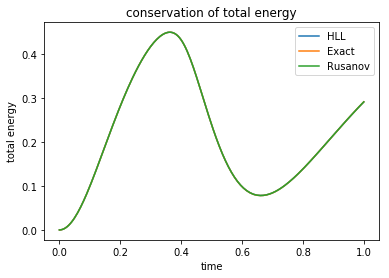

In [164]:
x, hist = fvsolve2system(riemann_shallow_hll, initial_shallow, n=200, limit=limit_vl, args=())

E_hll = []
times = []
for t, U in hist:
    times.append(t)
    Etemp=0
    h = U[1]
    you = U[1]/U[0]
    for j in range(len(U[1])):
        Etemp += 0.5*h[j]*you[j]**2 + 0.5 * h[j]**2
    E_hll.append(Etemp/(j+1)) 

x, hist = fvsolve2system(riemann_shallow, initial_shallow, n=200, limit=limit_vl, args=())

E_exact = []
times = []
for t, U in hist:
    times.append(t)
    Etemp=0
    h = U[1]
    you = U[1]/U[0]
    for j in range(len(U[1])):
        Etemp += 0.5*h[j]*you[j]**2 + 0.5 * h[j]**2
    E_exact.append(Etemp/(j+1)) 

x, hist = fvsolve2system(riemann_shallow_rusanov, initial_shallow, n=200, limit=limit_vl, args=())

E_rus = []
times = []
for t, U in hist:
    times.append(t)
    Etemp=0
    h = U[1]
    you = U[1]/U[0]
    for j in range(len(U[1])):
        Etemp += 0.5*h[j]*you[j]**2 + 0.5 * h[j]**2
    E_rus.append(Etemp/(j+1)) 

pyplot.plot(times,E_hll, label='HLL')
pyplot.plot(times,E_exact, label='Exact')
pyplot.plot(times,E_rus,label='Rusanov')
pyplot.xlabel('time')
pyplot.ylabel('total energy')
pyplot.title('conservation of total energy')
pyplot.legend(loc='best')
pyplot.show()

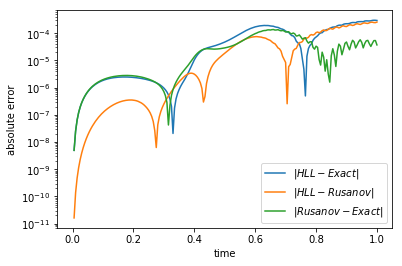

In [165]:
err_hex = [abs(a - b)  for a, b in zip(E_hll, E_exact)]
err_hrus = [abs(a - b)  for a, b in zip(E_hll, E_rus)]
err_rusex = [abs(a - b)  for a, b in zip(E_rus, E_exact)]
pyplot.semilogy(times,err_hex, label = r'$|HLL-Exact|$')
pyplot.semilogy(times,err_hrus, label = r'$|HLL-Rusanov|$')
pyplot.semilogy(times,err_rusex, label = r'$|Rusanov-Exact|$')
pyplot.xlabel('time')
pyplot.ylabel('absolute error')
pyplot.legend(loc='best')
pyplot.show()

Now let us examine the evolution of the conservation of total energy in time, with initial conditions that exhibit subsonic waves for all time. We use an HLL solver and compare to exact and Rusanov solvers.

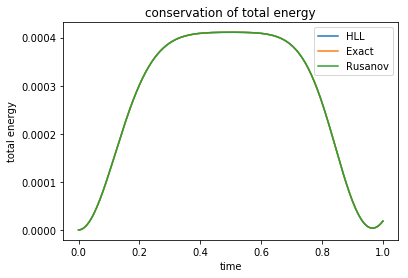

In [154]:
x, hist = fvsolve2system(riemann_shallow_hll, initial_shallow_sub, n=200, limit=limit_vl, args=())

E_hll = []
times = []
for t, U in hist:
    times.append(t)
    Etemp=0
    h = U[1]
    you = U[1]/U[0]
    for j in range(len(U[1])):
        Etemp += 0.5*h[j]*you[j]**2 + 0.5 * h[j]**2
    E_hll.append(Etemp/(j+1)) 

x, hist = fvsolve2system(riemann_shallow, initial_shallow_sub, n=200, limit=limit_vl, args=())

E_exact = []
times = []
for t, U in hist:
    times.append(t)
    Etemp=0
    h = U[1]
    you = U[1]/U[0]
    for j in range(len(U[1])):
        Etemp += 0.5*h[j]*you[j]**2 + 0.5 * h[j]**2
    E_exact.append(Etemp/(j+1)) 

x, hist = fvsolve2system(riemann_shallow_rusanov, initial_shallow_sub, n=200, limit=limit_vl, args=())

E_rus = []
times = []
for t, U in hist:
    times.append(t)
    Etemp=0
    h = U[1]
    you = U[1]/U[0]
    for j in range(len(U[1])):
        Etemp += 0.5*h[j]*you[j]**2 + 0.5 * h[j]**2
    E_rus.append(Etemp/(j+1)) 

pyplot.plot(times,E_hll, label='HLL')
pyplot.plot(times,E_exact, label='Exact')
pyplot.plot(times,E_rus,label='Rusanov')
pyplot.xlabel('time')
pyplot.ylabel('total energy')
pyplot.title('conservation of total energy')
pyplot.legend(loc='best')
pyplot.show()


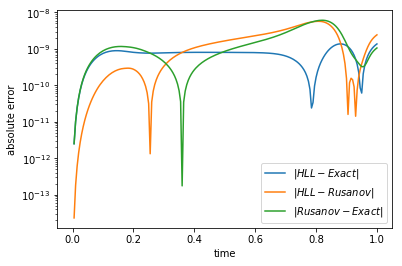

In [161]:
err_hex = [abs(a - b)  for a, b in zip(E_hll, E_exact)]
err_hrus = [abs(a - b)  for a, b in zip(E_hll, E_rus)]
err_rusex = [abs(a - b)  for a, b in zip(E_rus, E_exact)]
pyplot.semilogy(times,err_hex, label = r'$|HLL-Exact|$')
pyplot.semilogy(times,err_hrus, label = r'$|HLL-Rusanov|$')
pyplot.semilogy(times,err_rusex, label = r'$|Rusanov-Exact|$')
pyplot.xlabel('time')
pyplot.ylabel('absolute error')
pyplot.legend(loc='best')
pyplot.show()

These numerical experiments suggest that the solver used does not significantly impact the evolution of total conserved energy in time. 

Let us then experiment the effect of the choice of limiter using the HLL solver

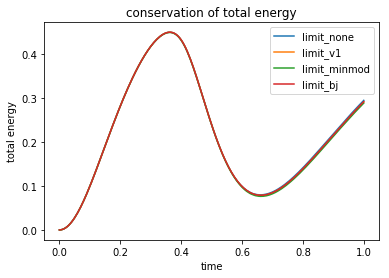

In [166]:
x, hist = fvsolve2system(riemann_shallow_hll, initial_shallow, n=200, limit=limit_none, args=())

E_none = []
times = []
for t, U in hist:
    times.append(t)
    Etemp=0
    h = U[1]
    you = U[1]/U[0]
    for j in range(len(U[1])):
        Etemp += 0.5*h[j]*you[j]**2 + 0.5 * h[j]**2
    E_none.append(Etemp/(j+1)) 

x, hist = fvsolve2system(riemann_shallow_hll, initial_shallow, n=200, limit=limit_vl, args=())

E_v1 = []
times = []
for t, U in hist:
    times.append(t)
    Etemp=0
    h = U[1]
    you = U[1]/U[0]
    for j in range(len(U[1])):
        Etemp += 0.5*h[j]*you[j]**2 + 0.5 * h[j]**2
    E_v1.append(Etemp/(j+1)) 

x, hist = fvsolve2system(riemann_shallow_hll, initial_shallow, n=200, limit=limit_minmod, args=())

E_minmod = []
times = []
for t, U in hist:
    times.append(t)
    Etemp=0
    h = U[1]
    you = U[1]/U[0]
    for j in range(len(U[1])):
        Etemp += 0.5*h[j]*you[j]**2 + 0.5 * h[j]**2
    E_minmod.append(Etemp/(j+1)) 
    
x, hist = fvsolve2system(riemann_shallow_hll, initial_shallow, n=200, limit=limit_bj, args=())

E_bj = []
times = []
for t, U in hist:
    times.append(t)
    Etemp=0
    h = U[1]
    you = U[1]/U[0]
    for j in range(len(U[1])):
        Etemp += 0.5*h[j]*you[j]**2 + 0.5 * h[j]**2
    E_bj.append(Etemp/(j+1)) 

pyplot.plot(times,E_none, label='limit_none')
pyplot.plot(times,E_v1, label='limit_v1')
pyplot.plot(times,E_minmod,label='limit_minmod')
pyplot.plot(times,E_bj,label='limit_bj')
pyplot.xlabel('time')
pyplot.ylabel('total energy')
pyplot.title('conservation of total energy')
pyplot.legend(loc='best')
pyplot.show()

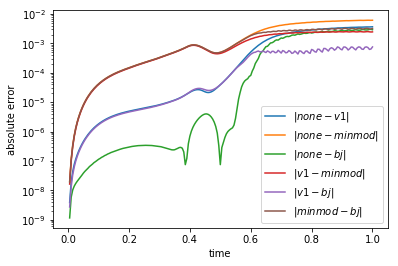

In [167]:
err_nv = [abs(a - b)  for a, b in zip(E_none, E_v1)]
err_nmin = [abs(a - b)  for a, b in zip(E_none, E_minmod)]
err_nbj = [abs(a - b)  for a, b in zip(E_none, E_bj)]
err_vminmod = [abs(a - b)  for a, b in zip(E_v1, E_minmod)]
err_vbj = [abs(a - b)  for a, b in zip(E_v1, E_bj)]
err_minbj = [abs(a - b)  for a, b in zip(E_minmod, E_bj)]
pyplot.semilogy(times,err_nv, label = r'$|none-v1|$')
pyplot.semilogy(times,err_nmin, label = r'$|none-minmod|$')
pyplot.semilogy(times,err_nbj, label = r'$|none-bj|$')
pyplot.semilogy(times,err_vminmod, label = r'$|v1-minmod|$')
pyplot.semilogy(times,err_vbj, label = r'$|v1-bj|$')
pyplot.semilogy(times,err_minbj, label = r'$|minmod-bj|$')
pyplot.xlabel('time')
pyplot.ylabel('absolute error')
pyplot.legend(loc='best')
pyplot.show()

These experiments suggest that the solution does indeed depend on the choice of limiter.